In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [68]:
train_ds = datasets.MNIST(root="./mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root="./mnist", train=False, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:02<00:00, 3389876.34it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1942896.22it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1586378.08it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18843252.99it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [69]:
n_train = len(train_ds)

In [70]:
from torch.utils.data import random_split

torch.manual_seed(1)

train_ds, val_ds = random_split(train_ds, [int(0.85*n_train), n_train-int(0.85*n_train)])

In [71]:
len(train_ds), len(val_ds)

(51000, 9000)

In [72]:
import math
def plot_imgs(num_imgs, dataset):
    ims = torch.randint(0,len(dataset), size=(num_imgs,))
    nrows = math.floor(num_imgs**0.5)
    ncols = math.ceil(num_imgs**0.5)
    _, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
    for i, im in enumerate(ims):
        row, col = divmod(i, ncols)
        axs[row,col].imshow(dataset[im][0].view(28,28,1).detach(), cmap="Greys")
        #axs[row,col].axis("off")

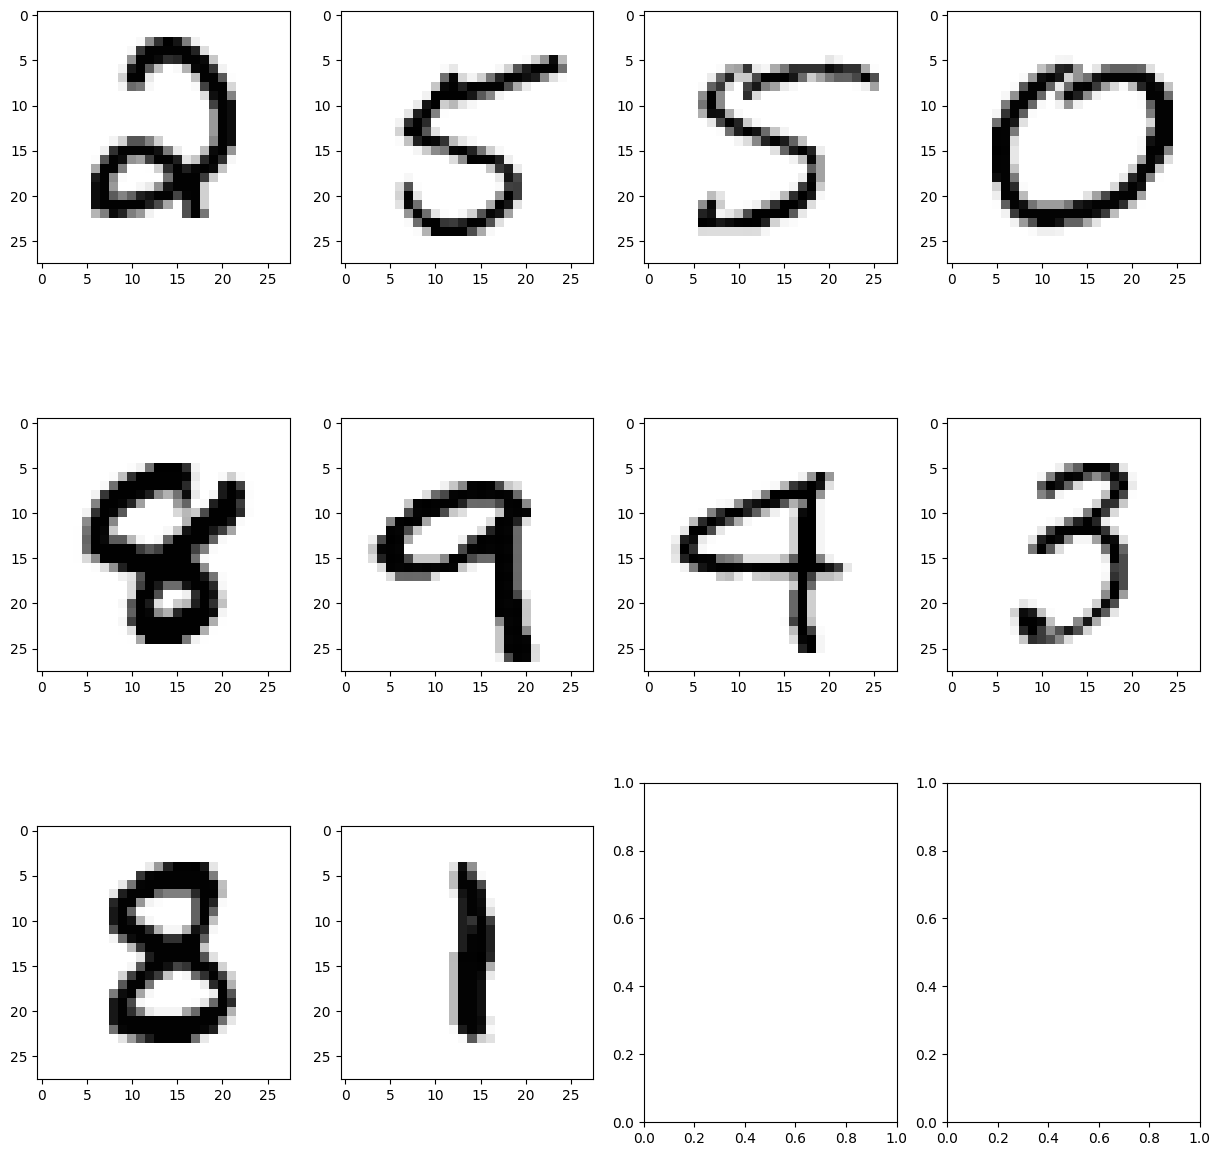

In [73]:
plot_imgs(10, train_ds)

In [74]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64,shuffle=False)
test_loader = DataLoader(train_ds, batch_size=64, shuffle=False)

# Checke Label-Verteilung

In [75]:
from collections import Counter

cntr = Counter()
total = 0
for _, labels in train_loader:
    total += labels.shape[0]
    cntr.update(labels.tolist())

cntr
for label, count in cntr.items():
    print(f"Label {label}: {count/total:.3f}")

Label 0: 0.098
Label 6: 0.099
Label 9: 0.099
Label 2: 0.099
Label 1: 0.112
Label 3: 0.103
Label 7: 0.105
Label 4: 0.097
Label 8: 0.098
Label 5: 0.090


In [76]:
def accuracy_fn(model, dataloader):
    correct = 0
    total = 0
    model = model.eval()
    for features, labels in dataloader:
        with torch.inference_mode():
            logits = model(features)
        y_pred = torch.argmax(logits, dim=1)
        compare = labels == y_pred
        correct += torch.sum(compare)
        total += len(compare)
    return correct/total

In [98]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=64, hidden_layers = 2):
        super().__init__()
        layers = [nn.Linear(in_features=in_features, out_features=hidden_units), nn.ReLU()]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, out_features))

        self.stack = nn.Sequential(
            *layers
        )
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.stack(x)

In [106]:
import torch.nn.functional as F

mlp = MLP(in_features=28*28, out_features=10, hidden_units=32, hidden_layers=1)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=0.01)

history = {
    "train_losses": [],
    "train_accs": [],
    "val_accs": []
}

epochs = 15
for epoch in range(epochs):

    mlp = mlp.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        logits = mlp(features)

        train_loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()

        train_loss.backward()
        optimizer.step()
        history["train_losses"].append(train_loss.detach())

        if batch_idx%200 == 0:
            train_acc = accuracy_fn(mlp, train_loader)
            test_acc = accuracy_fn(mlp, val_loader)

            history["train_accs"].append(train_acc.detach())
            history["val_accs"].append(test_acc.detach())
            print(f"Batch {batch_idx}: {train_loss}")

    print(f"Epoch: {epoch+1}/{epochs} | Train acc: {history['train_accs'][-1]:.3f} |  Val acc: {history['val_accs'][-1]:.3f}")


Batch 0: 2.297055721282959
Batch 200: 0.32161271572113037
Batch 400: 0.14450016617774963
Batch 600: 0.1615234762430191
Epoch: 1/15 | Train acc: 0.942 |  Val acc: 0.937
Batch 0: 0.19689786434173584
Batch 200: 0.1143321767449379
Batch 400: 0.1405983716249466
Batch 600: 0.05967988073825836
Epoch: 2/15 | Train acc: 0.955 |  Val acc: 0.943
Batch 0: 0.05545973405241966
Batch 200: 0.31832757592201233
Batch 400: 0.06138422340154648
Batch 600: 0.06065138429403305
Epoch: 3/15 | Train acc: 0.963 |  Val acc: 0.954
Batch 0: 0.15255942940711975
Batch 200: 0.06977567076683044
Batch 400: 0.07203246653079987
Batch 600: 0.11681373417377472
Epoch: 4/15 | Train acc: 0.962 |  Val acc: 0.948
Batch 0: 0.056462544947862625
Batch 200: 0.24315862357616425
Batch 400: 0.20790180563926697
Batch 600: 0.11435935646295547
Epoch: 5/15 | Train acc: 0.968 |  Val acc: 0.955
Batch 0: 0.09423711895942688
Batch 200: 0.3982582092285156
Batch 400: 0.12342403084039688
Batch 600: 0.1974075436592102
Epoch: 6/15 | Train acc: 0.96

(0.0, 1.0)

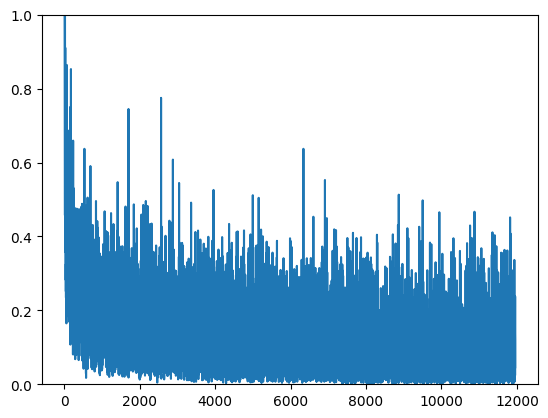

In [107]:
plt.plot(history["train_losses"])
plt.ylim((0,1))

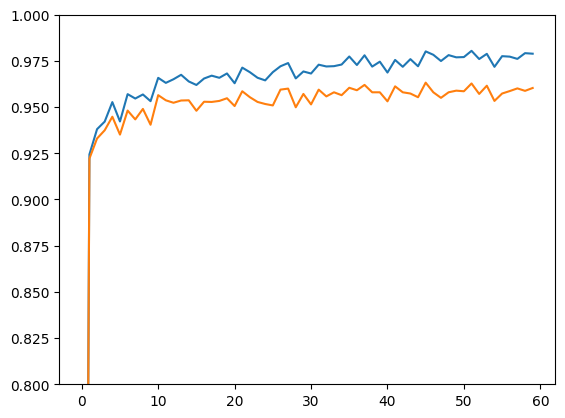

In [108]:
plt.plot(history["train_accs"])
plt.plot(history["val_accs"])
plt.ylim((0.8,1));

In [109]:
accuracy_fn(mlp, test_loader)

tensor(0.9792)

In [110]:
sum([p.numel() for p in mlp.parameters()])

26506